### Prepare list of sample files ###

Parse CSV files and fill filenames and measurements arrays.

Source directories:
- CCW - Two laps in counter-clockwise direction.
- CW - Two laps in clockwise direction.
- CCW_Minus - car driving in counter-clockwise was intentionally pushed out of the road and then returned back. Only measures with the negative steering angle should be recorded.
- CCW_Plus - car driving in clockwise was intentionally pushed out of the road and then returned back. Only measures with the positive steering angle should be recorded.


In [84]:
import csv
import cv2
import numpy as np

records=[]

class Sample():
    def __init__(self, image_path, angle, flip):
        self.image_path = image_path
        self.angle = angle
        self.flip = flip
    

def importCsv(path, negativeOnly = None, positiveOnly = None):
    lines = []
    with open('./data/' + path + '/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            if (len(line) > 1):
                lines.append(line)
    print(path, len(lines), 'records')        
    
    for line in lines:
        centerImage = './data/' + path + '/IMG/' + line[0].split('\\')[-1]
        leftImage = './data/' + path + '/IMG/' + line[1].split('\\')[-1]
        rightImage = './data/' + path + '/IMG/' + line[2].split('\\')[-1]
        measurement = float(line[3])
        
        if negativeOnly is not None and measurement >= 0:
            continue
        
        if positiveOnly is not None and measurement <= 0:
            continue
        
        records.append(Sample(centerImage, measurement, False))
        #records.append(Sample(leftImage, measurement + 0.1, False))
        #records.append(Sample(rightImage, measurement - 0.1, False))
        
        records.append(Sample(centerImage, measurement, True))
        #records.append(Sample(leftImage,  measurement + 0.1, True))
        #records.append(Sample(rightImage, measurement - 0.1, True))
        
        
importCsv('CCW')
importCsv('CW')
importCsv('CCW_Minus', negativeOnly = True)
importCsv('CW_Plus', positiveOnly = True)

samples = np.array(records)

print('Total samples: ', len(samples))


CCW 2141 records
CW 2038 records
CCW_Minus 1653 records
CW_Plus 1180 records
Total samples:  10306


### Data generators ###

Train samples:  8244
Validation samples:  2062


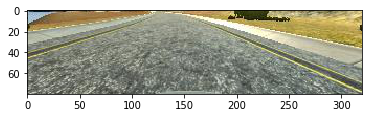

-0.04424779


In [88]:
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

train_samples, valid_samples = train_test_split(samples, test_size=0.2, shuffle=True)

ch, row, col = 3, 80, 320  # Trimmed image format

print('Train samples: ', len(train_samples))
print('Validation samples: ', len(valid_samples))

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        np.random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for sample in batch_samples:
                image = cv2.imread(sample.image_path)
                angle = sample.angle
                
                if (sample.flip):
                    image = cv2.flip(image, 1)
                    angle = -angle
                
                # Crop
                image = image[60:140]
                
                images.append(image)
                angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(valid_samples, batch_size=32)

test = next(train_generator)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(cv2.cvtColor(test[0][0], cv2.COLOR_BGR2RGB))
plt.show()

print(test[1][0])


### Create the Network###

In [89]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda

model = Sequential()

model.add(Lambda(lambda x: x/127.5 - 1.0,
        input_shape=(row, col, ch),
        output_shape=(row, col, ch)))

model.add(Flatten(input_shape=(row, col, ch)))
model.add(Dense(1))


In [91]:
model.compile(loss='mse', optimizer='adam')

model.fit_generator(
    train_generator, 
    samples_per_epoch = len(train_samples), 
    validation_data = validation_generator, 
    nb_val_samples = len(valid_samples), 
    nb_epoch=5
)


model.save('model.h5')
print('model saved')


Epoch 1/5
8244/8244 [==============================] - 10s - loss: 4.5471 - val_loss: 3.1870
Epoch 2/5
8244/8244 [==============================] - 10s - loss: 2.9713 - val_loss: 3.1878
Epoch 3/5
8244/8244 [==============================] - 10s - loss: 3.7307 - val_loss: 5.6492
Epoch 4/5
8244/8244 [==============================] - 10s - loss: 6.2085 - val_loss: 3.5132
Epoch 5/5
8244/8244 [==============================] - 10s - loss: 3.4428 - val_loss: 1.6826
model saved
